## Data Preparation and Preprocessing

1. MIDI file loading and validation
2. Feature extraction
3. Data augmentation
4. Stratified train/val/test splitting
5. Dataset visualization

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from data_preprocess_utils import (ComposerDataset, 
                                  create_stratified_splits,
                                  plot_feature_distribution)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Dataset Configuration

In [3]:
config = {
    "data_dir": "midiclassics",
    "composers": ["bach", "beethoven", "chopin", "mozart"],
    "max_seq_length": 500,  # Suitable for LSTM/CNN
    "test_size": 0.15,      # 15% for test
    "val_size": 0.15,       # 15% for validation
    "batch_size": 32,
    "augment_train": True   # Enable augmentation for training set
}

## Load and Process MIDI Files

In [4]:
print("Initializing dataset...")
full_dataset = ComposerDataset(
    data_dir=config["data_dir"],
    composers=config["composers"],
    max_length=config["max_seq_length"],
    augment=False  # We'll apply augmentation separately
)

# Display dataset statistics
print(f"\nTotal samples loaded: {len(full_dataset)}")
print(f"Feature shape: {full_dataset[0]['features'].shape}")
print("Class distribution:")
for i, composer in enumerate(config["composers"]):
    count = sum(1 for _, label in full_dataset.samples if label == i)
    print(f"- {composer.capitalize()}: {count} samples")

Initializing dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:25<00:00, 10.06it/s]


Total samples loaded: 1529
Feature shape: torch.Size([500, 4])
Class distribution:
- Bach: 925 samples
- Beethoven: 212 samples
- Chopin: 136 samples
- Mozart: 256 samples


## Create Stratified Splits

In [5]:
print("\nCreating stratified splits...")
train_set, val_set, test_set = create_stratified_splits(
    dataset=full_dataset,
    test_size=config["test_size"],
    val_size=config["val_size"],
    random_state=SEED
)

# Verify split sizes
print(f"\nSplit sizes:")
print(f"- Training set: {len(train_set)} samples")
print(f"- Validation set: {len(val_set)} samples")
print(f"- Test set: {len(test_set)} samples")


Creating stratified splits...

Split sizes:
- Training set: 1069 samples
- Validation set: 230 samples
- Test set: 230 samples


## Initialize Data Loaders

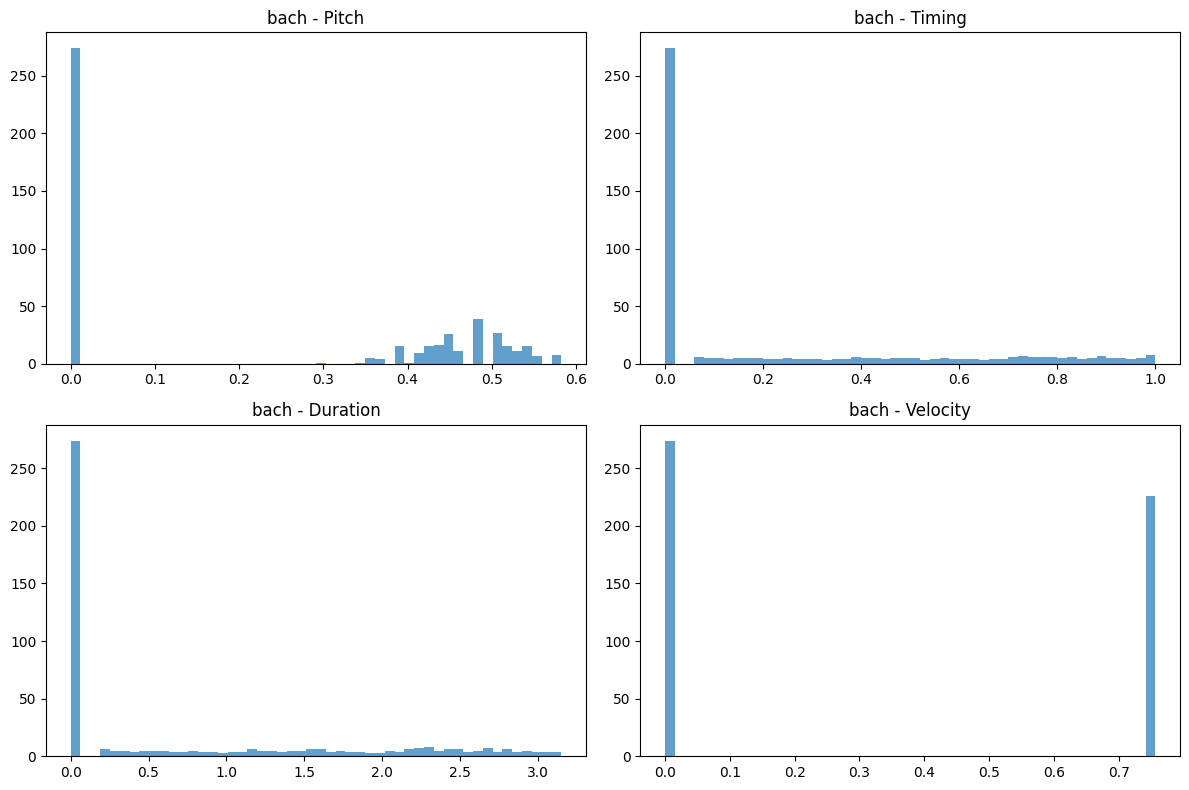

In [6]:
# Create weighted sampler for class imbalance
train_labels = [full_dataset.samples[i][1] for i in train_set.indices]
sampler = WeightedRandomSampler(
    weights=full_dataset.class_weights[train_labels],
    num_samples=len(train_labels),
    replacement=True
)

# Initialize data loaders
train_loader = DataLoader(
    train_set,
    batch_size=config["batch_size"],
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_set,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2
)

# Plot feature distributions
sample_idx = np.random.choice(len(train_set))
sample = train_set[sample_idx]
plot_feature_distribution(
    features=sample['features'].numpy(),
    composer=config["composers"][sample['label'].item()]
)

## Verify Data Loaders

In [7]:
# Check hardware acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = (device.type == 'cuda')
print(f"\nUsing device: {device}")
print(f"Pin memory enabled: {pin_memory}")

# Create weighted sampler for class imbalance
train_labels = [full_dataset.samples[i][1] for i in train_set.indices]
sampler = WeightedRandomSampler(
    weights=full_dataset.class_weights[train_labels],
    num_samples=len(train_labels),
    replacement=True
)

# Initialize data loaders
loaders_config = {
    'batch_size': config["batch_size"],
    'num_workers': 4 if pin_memory else 2,  # Fewer workers if no GPU
    'pin_memory': pin_memory
}

train_loader = DataLoader(
    train_set,
    sampler=sampler,
    **loaders_config
)

# Validation and test loaders with reduced workers
val_loader = DataLoader(
    val_set,
    shuffle=False,
    **{**loaders_config, 'num_workers': 2}
)

test_loader = DataLoader(
    test_set,
    shuffle=False,
    **{**loaders_config, 'num_workers': 2}
)

print("\nData loaders initialized:")
print(f"- Training batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Test batches: {len(test_loader)}")


Using device: cpu
Pin memory enabled: False

Data loaders initialized:
- Training batches: 34
- Validation batches: 8
- Test batches: 8


## Save Processed Data

In [8]:
import pickle

# Create save directory
save_dir = "processed_data"
os.makedirs(save_dir, exist_ok=True)

# Save dataset splits
torch.save({
    'train_indices': train_set.indices,
    'val_indices': val_set.indices,
    'test_indices': test_set.indices,
    'class_weights': full_dataset.class_weights,
    'config': config
}, os.path.join(save_dir, 'splits.pt'))

# Save sample features for inspection
sample_data = {
    'features': sample['features'].numpy(),
    'label': sample['label'].item()
}
with open(os.path.join(save_dir, 'sample_features.pkl'), 'wb') as f:
    pickle.dump(sample_data, f)

print(f"\nSaved processed data to '{save_dir}/'")

# %% [markdown]
# ## Step 8: Verify Class Distribution in Splits

# %%
def print_split_stats(dataset, split_set, name):
    labels = [dataset.samples[i][1] for i in split_set.indices]
    counts = torch.bincount(torch.tensor(labels))
    print(f"\n{name.upper()} SET CLASS DISTRIBUTION:")
    for i, composer in enumerate(config["composers"]):
        print(f"- {composer.capitalize()}: {counts[i]} samples")

print_split_stats(full_dataset, train_set, "Training")
print_split_stats(full_dataset, val_set, "Validation")
print_split_stats(full_dataset, test_set, "Test")


Saved processed data to 'processed_data/'

TRAINING SET CLASS DISTRIBUTION:
- Bach: 647 samples
- Beethoven: 148 samples
- Chopin: 95 samples
- Mozart: 179 samples

VALIDATION SET CLASS DISTRIBUTION:
- Bach: 139 samples
- Beethoven: 32 samples
- Chopin: 21 samples
- Mozart: 38 samples

TEST SET CLASS DISTRIBUTION:
- Bach: 139 samples
- Beethoven: 32 samples
- Chopin: 20 samples
- Mozart: 39 samples
